## Data Analysis:

In [1]:
import os
import matplotlib.pyplot as plt
import cv2 
import numpy as np
import tensorflow as tf

from tensorflow.python.keras.layers import Add, Conv2D, Input, Lambda, Dropout, Concatenate, Reshape, BatchNormalization, DepthwiseConv2D
from model.wdsr_edge import edge_convert

#from tensorflow.python.keras.models import Model
from keras.models import Model

from data import Thermal
from model.nmodel import wdsr_b
from train import WdsrTrainer
from PIL import Image
from numpy import asarray

%matplotlib inline

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## High Pass Filter:

In [23]:
import scipy.integrate as integrate
import scipy.special as special

In [20]:
def high_pass_filter(x_in):
    x = tf.keras.utils.normalize(x_in, axis=-1, order=1)
    x = tf.constant(x.reshape(1,x_in.shape[0],x_in.shape[1], 1))
    lowpass = keras.layers.Conv2D(1, kernel_size=(5,5), padding='same', kernel_initializer=kernelInitializer_highpass, strides=(1,1))(x)
    highpass = x-lowpass

    x = tf.reshape(lowpass, [x_in.shape[0],x_in.shape[1]])
    
    return x

def kernelInitializer_highpass(shape, dtype=None):
    K = tf.constant(
        [s
            [0.003765,0.015019,0.023792,0.015019,0.003765],
            [0.015019,0.059912,0.094907,0.059912,0.015019],
            [0.023792,0.094907,0.150342,0.094907,0.023792],
            [0.015019,0.059912,0.094907,0.059912,0.015019],
            [0.003765,0.015019,0.023792,0.015019,0.003765]], dtype='float32')
    #create the missing dims.
    K = tf.reshape(K, (5, 5, 1, 1))

    #tile the last 2 axis to get the expected dims.
    x = tf.tile(K, (1, 1, shape[-2],shape[-1]))

    return x

In [21]:
from PIL import Image
import numpy as np
import cv2
import tensorflow as tf

import tensorflow_addons as tfa
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from scipy import misc
import keras.backend as K
import tensorflow_addons as tfa


from tensorflow.python.keras.layers import Add, Conv2D, Input, Lambda, Dropout, Concatenate, Reshape, BatchNormalization, DepthwiseConv2D, MaxPooling2D
from tensorflow.python.keras.models import Model

from model.common import normalize, denormalize, pixel_shuffle

path = f'demo/1064.png'
image = Image.open(path)
img = np.array(image)
print("Image Matrix: ")
print(img)
print(img.shape)

img_tensor = tf.keras.preprocessing.image.img_to_array(image)
filtered = high_pass_filter(img_tensor)
filtered.numpy()




Image Matrix: 
[[ 32  32  31 ...  37  36  37]
 [ 31  31  32 ...  37  37  36]
 [ 32  31  32 ...  37  37  37]
 ...
 [200 200 199 ... 193 192 194]
 [200 199 199 ... 194 193 194]
 [200 200 198 ... 193 194 195]]
(480, 640)


array([[0.48145497, 0.65129304, 0.693869  , ..., 0.693869  , 0.65129304,
        0.481455  ],
       [0.65129304, 0.8810431 , 0.93863803, ..., 0.93863803, 0.881043  ,
        0.65129304],
       [0.69386905, 0.93863803, 0.99999803, ..., 0.99999803, 0.93863803,
        0.693869  ],
       ...,
       [0.69386905, 0.93863803, 0.99999803, ..., 0.99999803, 0.93863803,
        0.693869  ],
       [0.65129304, 0.881043  , 0.93863803, ..., 0.93863803, 0.881043  ,
        0.651293  ],
       [0.481455  , 0.651293  , 0.693869  , ..., 0.693869  , 0.651293  ,
        0.48145497]], dtype=float32)

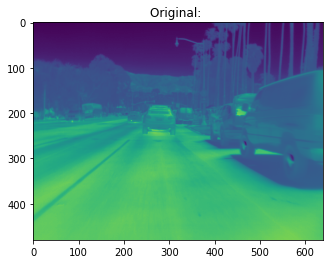

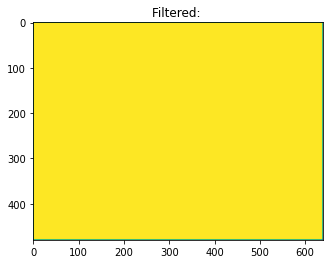

In [22]:
plt.title('Original: ')
plt.imshow(image)
plt.show()

plt.title('Filtered: ')
plt.imshow(filtered)
plt.show()

## Sobel, Kirsch, Prewitt:

Image Matrix: 
[[ 92  93  92 ...  74  73  72]
 [ 90  91  91 ...  76  75  72]
 [ 90  90  91 ...  74  71  70]
 ...
 [175 175 177 ... 176 176 176]
 [175 175 176 ... 177 176 176]
 [175 176 176 ... 177 176 176]]
(480, 640)
(480, 640, 1)
(1, 480, 640, 1)
Sobel: 
[[387.51773   363.00137   365.01233   ... 303.01486   298.10736
  311.1302   ]
 [365.0671      9.486833    4.472136  ...   7.071068   15.231546
  294.06122  ]
 [361.01245     5.656854    7.2111025 ...  24.698177   27.45906
  286.4472   ]
 ...
 [701.0064      5.8309517   3.1622777 ...   2.          2.
  704.01135  ]
 [701.00073     5.0990195   4.        ...   0.          3.1622777
  704.       ]
 [743.8777    701.0064    703.0064    ... 706.0028    705.0064
  746.7048   ]]
Kirsch: 
[[1370.  824.  826. ...  694.  693. 1100.]
 [ 840.   29.   12. ...   24.   46.  677.]
 [ 818.   18.   19. ...   61.   81.  682.]
 ...
 [1585.   14.    6. ...    7.   12. 1594.]
 [1580.   17.    8. ...    5.   10. 1584.]
 [2630. 1585. 1592. ... 1592. 1594. 2

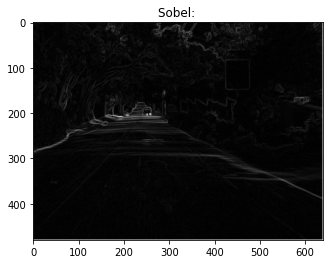

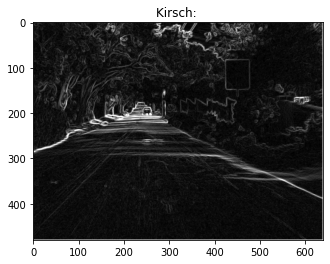

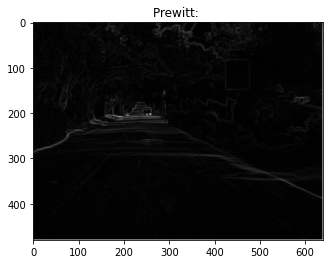

In [2]:
from PIL import Image
import numpy as np
import cv2

path = f'data/Thermal_train_HR/1064.png'
image = Image.open(path)
img = np.array(image)
print("Image Matrix: ")
print(img)
print(img.shape)
# converting to gray scale

img_tensor = tf.keras.preprocessing.image.img_to_array(image)
print(img_tensor.shape)
img_tensor = img_tensor.reshape(1,480,640, 1)
print(img_tensor.shape)
img_tensor = tf.convert_to_tensor(img_tensor)
# sobel, kirsch, prewitt = edge_convert(img_tensor,1)
sobel, kirsch, prewitt = edge_convert(img_tensor, 1)
print("Prewitt: ")
print(prewitt)
plt.title('Sobel: ')
plt.imshow(sobel)
plt.show()
plt.title('Kirsch: ')
plt.imshow(kirsch)
plt.show()
plt.title('Prewitt: ')
plt.imshow(prewitt)
plt.show()


In [6]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
img = cv2.imread(path,0)

kernelx = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
kernely = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
prewitt_x = cv2.filter2D(img, cv2.CV_32F, kernelx)
prewitt_y = cv2.filter2D(img, cv2.CV_32F, kernely)
prewittx = prewitt_x*prewitt_x
prewitty = prewitt_y*prewitt_y
prewitt = np.sqrt(prewittx + prewitty)
print(prewitt)


[[ 0.         2.         0.        ...  3.        10.         0.       ]
 [ 8.         6.3245554  3.1622777 ...  6.0827627 10.770329   6.       ]
 [ 3.         4.2426405  5.        ... 17.492855  20.248457  17.       ]
 ...
 [ 3.         3.6055512  2.236068  ...  1.         2.         2.       ]
 [ 2.         4.         3.1622777 ...  1.         2.236068   0.       ]
 [ 0.         3.         3.        ...  1.         3.         0.       ]]


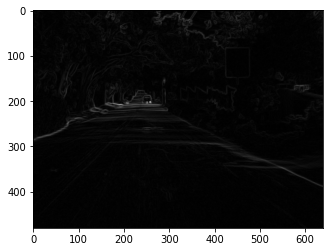

In [7]:
plt.imshow(prewitt,cmap='gray')
plt.show()

[[ 0.         2.         2.        ...  4.        12.         0.       ]
 [10.         9.486833   4.472136  ...  7.071068  15.231546   8.       ]
 [ 4.         5.656854   7.2111025 ... 24.698177  27.45906   22.       ]
 ...
 [ 4.         5.8309517  3.1622777 ...  2.         2.         4.       ]
 [ 2.         5.0990195  4.        ...  0.         3.1622777  0.       ]
 [ 0.         4.         4.        ...  2.         4.         0.       ]]
(480, 640)


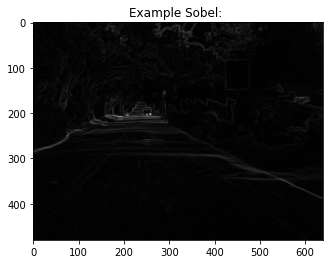

In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread(path,0)

sobelx = cv2.Sobel(img,cv2.CV_32F,1,0,ksize=3)
sobely = cv2.Sobel(img,cv2.CV_32F,0,1,ksize=3)
sobelx = sobelx*sobelx
sobely = sobely*sobely
sobel = np.sqrt(sobelx + sobely)
print(sobel)
print(sobel.shape)
plt.title('Example Sobel: ')
plt.imshow(sobel,cmap='gray')
plt.show()

In [1]:
import os
import matplotlib.pyplot as plt
import cv2 
import numpy as np
import tensorflow as tf

from tensorflow.python.keras.layers import Add, Conv2D, Input, Lambda, Dropout, Concatenate, Reshape, BatchNormalization, DepthwiseConv2D
from model.wdsr_edge import edge_convert

#from tensorflow.python.keras.models import Model
from keras.models import Model

from data import Thermal
from model.nmodel import wdsr_b
from train import WdsrTrainer
from PIL import Image
from numpy import asarray

%matplotlib inline

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
 def MeanGradientError(outputs, targets, weight=0):
        filter_x = tf.tile(tf.expand_dims(tf.constant([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype = outputs.dtype), axis = -1), [1, 1, outputs.shape[-1]])
        filter_x = tf.tile(tf.expand_dims(filter_x, axis = -1), [1, 1, 1, outputs.shape[-1]])
        filter_y = tf.tile(tf.expand_dims(tf.constant([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype = outputs.dtype), axis = -1), [1, 1, targets.shape[-1]])
        filter_y = tf.tile(tf.expand_dims(filter_y, axis = -1), [1, 1, 1, targets.shape[-1]])

        # output gradient
        output_gradient_x = tf.math.square(tf.nn.conv2d(outputs, filter_x, strides = 1, padding = 'VALID'))
        output_gradient_y = tf.math.square(tf.nn.conv2d(outputs, filter_y, strides = 1, padding = 'VALID'))

        #target gradient
        target_gradient_x = tf.math.square(tf.nn.conv2d(targets, filter_x, strides = 1, padding = 'VALID'))
        target_gradient_y = tf.math.square(tf.nn.conv2d(targets, filter_y, strides = 1, padding = 'VALID'))

        # square
        output_gradients = tf.math.sqrt(tf.math.add(output_gradient_x, output_gradient_y))
        target_gradients = tf.math.sqrt(tf.math.add(target_gradient_x, target_gradient_y))

        output_gradients = tf.keras.layers.ZeroPadding2D(padding=1)(output_gradients)
        target_gradients = tf.keras.layers.ZeroPadding2D(padding=1)(target_gradients)
        
        # compute mean gradient error
        shape = output_gradients.shape[1:3]
        mge = tf.math.reduce_sum(tf.math.squared_difference(output_gradients, target_gradients) / (shape[0] * shape[1]))

        return output_gradients,target_gradients, mge
    

In [3]:
from PIL import Image
import numpy as np
import cv2

path = f'demo/1064.png'
image = Image.open(path)
img = np.array(image)
print("Image Matrix: ")
print(img)
print(img.shape)

img_tensor = tf.keras.preprocessing.image.img_to_array(image)

print(img_tensor.shape)
img_tensor = img_tensor.reshape(1,480,640, 1)
print(img_tensor.shape)

img_tensor = tf.convert_to_tensor(img_tensor)

x, y, mge = MeanGradientError(img_tensor, img_tensor, 0)


Image Matrix: 
[[ 32  32  31 ...  37  36  37]
 [ 31  31  32 ...  37  37  36]
 [ 32  31  32 ...  37  37  37]
 ...
 [200 200 199 ... 193 192 194]
 [200 199 199 ... 194 193 194]
 [200 200 198 ... 193 194 195]]
(480, 640)
(480, 640, 1)
(1, 480, 640, 1)


In [4]:
import numpy as np
xn = x.numpy()
print(xn)

[[[[132.9436   ]
   [125.004    ]
   [127.00394  ]
   ...
   [149.0302   ]
   [147.0034   ]
   [154.14928  ]]

  [[125.004    ]
   [  1.4142135]
   [  3.1622777]
   ...
   [  4.472136 ]
   [  2.828427 ]
   [147.0034   ]]

  [[124.01613  ]
   [  1.4142135]
   [  4.       ]
   ...
   [  5.0990195]
   [  2.828427 ]
   [147.0034   ]]

  ...

  [[798.01     ]
   [  2.828427 ]
   [  3.1622777]
   ...
   [  6.3245554]
   [  5.0990195]
   [769.01624  ]]

  [[798.       ]
   [  5.0990195]
   [  2.828427 ]
   ...
   [  2.828427 ]
   [  5.8309517]
   [772.0104   ]]

  [[847.11395  ]
   [797.0157   ]
   [798.       ]
   ...
   [774.       ]
   [774.0103   ]
   [821.6581   ]]]]


In [ ]:
path = f'nkirsch.png'
image = Image.open(path)
data = asarray(image)
new = data.astype(np.uint8)
image2 = Image.fromarray(new)

image2.save('testing.png')


In [ ]:
print(img)

In [ ]:
path = f'data/Thermal_train_HR/1064.png'
image = Image.open(path)
img = np.array(image)
print(img.shape)
data = asarray(image)
print(data)
plt.hist(data, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [ ]:
def gauss2D(shape=(3,3),sigma=0.5):

    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h


def gaussFilter():
    kernel_size = 3
    kernel_weights = gauss2D(shape=(kernel_size,kernel_size))
    
    
    in_channels = 1  # the number of input channels
    kernel_weights = np.expand_dims(kernel_weights, axis=-1)
    kernel_weights = np.repeat(kernel_weights, in_channels, axis=-1) # apply the same filter on all the input channels
    kernel_weights = np.expand_dims(kernel_weights, axis=-1)  # for shape compatibility reasons
    
    
    inp = Input(shape=(3,3,1))
    g_layer = DepthwiseConv2D(kernel_size, use_bias=False, padding='same')(inp)
    model_network = Model(inputs=inp, outputs=g_layer)
    model_network.layers[1].set_weights([kernel_weights])
    model_network.trainable= False #can be applied to a given layer only as well
        
    return model_network
    model_network = Model(input=inp, output=g_layer)
    model_network.layers[1].set_weights([kernel_weights])
    model_network.trainable= False #can be applied to a given layer only as well

In [ ]:
a = np.array([[[1, 2, 3], [4, 5, 6], [4, 5, 6]]])
filt = gaussFilter()
print(a.reshape((1,3,3,1)))
print(filt.predict(a.reshape(1,3,3,1)))

In [9]:
import tensorflow as tf
zero = tf.zeros([2,2])
one = [1,2]
print(tf.add(zero,one))

tf.Tensor(
[[1. 2.]
 [1. 2.]], shape=(2, 2), dtype=float32)
